In [129]:
#import dependencies

#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [111]:
# Python SQL toolkit and Object Relational Mapper
    #import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.sql import desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [32]:
# Find the most recent date in the data set.

results = session.query(func.max(measurement.date))
for date in results:
    print(date)

#dt.date(result)
print(dt.datetime.strptime(results[0][0], '%Y-%m-%d').date())


('2017-08-23',)
2017-08-23


Index(['id', 'station', 'date', 'prcp', 'tobs'], dtype='object')


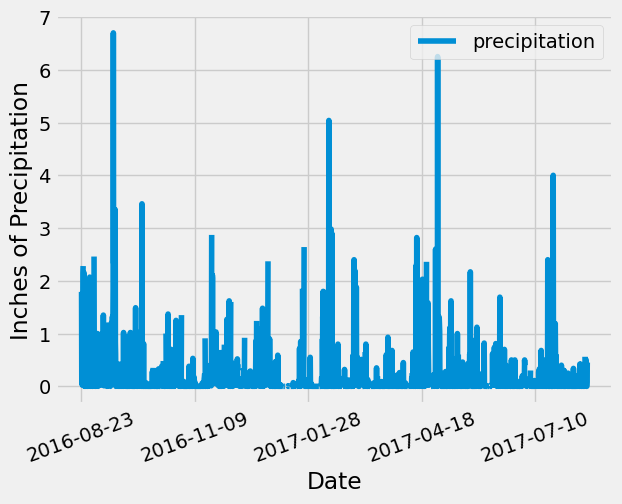

In [69]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent = dt.datetime.strptime(results[0][0], '%Y-%m-%d').date()
one_year = most_recent - dt.timedelta(weeks = 52.1429)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement).filter(measurement.date >= one_year)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurement_df = pd.read_sql_query(query.statement, engine)
print(measurement_df.columns)
measurement_df.columns = ['id', 'station', 'date', 'precipitation', 'tobs']

# Sort the dataframe by date
measurement_df = measurement_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(x = 'date', y = 'precipitation', xlabel = 'Date', ylabel = 'Inches of Precipitation', rot= 20).legend(loc = 'upper right')

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurement_df[['precipitation']].describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [99]:
# Design a query to calculate the total number of stations in the dataset

#option 1 ####
unique_station = []

#query the results
results = session.query(station.station)

#append station id if not already in list
for result in results:
    if result not in unique_station:
        unique_station.append(result)
        print(result)
#print the lenght to determine length of unique stations
print(len(unique_station))

#option 2

#use function to calculate the number of stations. Tried group_by but got an error, so stuck with this
total_stations = session.query(func.count(station.station)).\
                all()
total_stations


('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)
9


[(9,)]

In [116]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
query = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station)
for station in query:
    print(station)
    
# List the stations and their counts in descending order.
results = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(desc(func.count(measurement.station))).\
    all()

print(results)
    
    


('USC00511918', 1979)
('USC00513117', 2709)
('USC00514830', 2202)
('USC00516128', 2612)
('USC00517948', 1372)
('USC00518838', 511)
('USC00519281', 2772)
('USC00519397', 2724)
('USC00519523', 2669)
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [122]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#extract the station with highest number of observations
active_station = results[0][0]

#select the minimum, maximum, and average of the temperature observations
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]

#query the selection, grouping by station, filtering to only include the most active station
session.query(*sel).\
    group_by(measurement.station).\
    filter(measurement.station == active_station).\
    all()

[(54.0, 85.0, 71.66378066378067)]

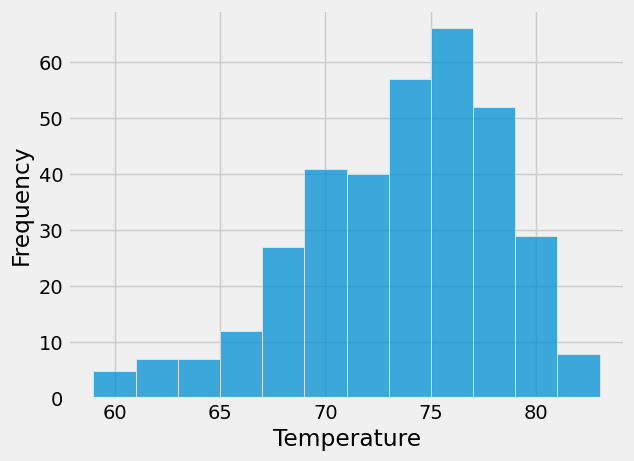

In [141]:
# Using the most active station id, Query the last 12 months of temperature observation data for this station

#create a selection query to extract the temperature and date
sel = [measurement.tobs, measurement.date]

#query the data
temp_result = session.query(*sel).\
    filter(measurement.date > one_year).\
    filter(measurement.station == active_station).\
        all()
#convert into a pandas dataframe for Seaborn
temp_result = pd.DataFrame(temp_result, columns = ['tobs', 'date'])

#and plot the results as a histogram
sns.histplot(data = temp_result, x = 'tobs', bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout
plt.show()


# Close Session

In [16]:
# Close Session
session.close()